# Blob Detection in low and high res
By Shooby on Sep 23rd <br>
Last edited: Sep 24 <br>


In [88]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
import skimage


def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im

def brightest_center(im, r = 10):
    
    '''This function is to check whether the central object of the 
    image is the brightest compared to its neighbors in the given cutout.
    Central is defined with a 10x10 pixel square in the center'''
    
    a0,a1 = np.unravel_index(np.argmax(im, axis=None), im.shape)
    ans = False
    if ((a0>((im.shape[0]-r)/2)) & (a0<((im.shape[0]+r)/2)) & (a1>((im.shape[1]-r)/2)) & (a1<((im.shape[0]+r)/2))):
        ans = True
    
    return ans

def go_lowres(galax,out_size=21, noise_sigma=2):
    '''This function is to take high resolution galaxy cutout and go to 
    a lower pixelscale, resolution and more noise'''
    
    from photutils import create_matching_kernel
    from skimage.transform import downscale_local_mean
    from astropy.convolution import convolve
    
    psf = pyfits.getdata('psf_i.fits')
    psf = downscale_local_mean(psf,(3,3))
    psf = psf[7:-8,7:-8]
    psf_hsc = pyfits.getdata('psf-calexp-s16a_wide-HSC-I-15827-7,2-236.00000-42.00000.fits')
    psf_hsc = psf_hsc[0:41,1:42]
    kern = create_matching_kernel(psf,psf_hsc)

    
    im = galax+np.random.normal(0,noise_sigma,galax.shape)
    img = convolve(im,kern)
    outp = np.array(Image.fromarray(img).resize((out_size,out_size)))

    return outp
    
%matplotlib inline

In [89]:
def galblend(gals=1, lim_hmag=24, plot_it=True):
    
    '''This is to put together two candels GOODS_S galaxies into a single 64x64 cutout.
    I make sure in each cutout the central galaxy is brightest object in the cutout so 
    in rescaling and adding two components still show up. Also, one galaxy is put at 
    the center and the second in some random distance from it. both cutouts are rotated with
    a random angle. Cutouts are from HST H band for now.'''
    
    ## reading GOODS-S catalog and initial selection on objects
    gs = pyfits.getdata('../../WFIRST_WPS/CANDELS_fits/gds.fits')
    sel1 = (gs['zbest']>0.1)&(gs['zbest']<5.0)&(gs['CLASS_STAR']<0.95)&(gs['Hmag']<lim_hmag)&(gs['FWHM_IMAGE']>2)
    ra, dec,red = gs['RA_1'][sel1],gs['DEC_1'][sel1],gs['zbest'][sel1]
    
    im = np.zeros([64,64])
   
    data1 = np.zeros([80,80])
    da1 = np.zeros([64,64])
    while not(brightest_center(data1)):
        n = np.int(np.random.uniform(0,len(ra)-1))
        data1 = cut(ra[n],dec[n],40,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')
        z1 = red[n]
    
    angle = np.random.uniform(0,180)
    s = ndimage.rotate(data1,angle,mode='nearest',reshape=False)
    da1 = s[8:-8,8:-8]
    im += da1
    
    da2 = np.zeros([gals,64,64])
    z2 = np.zeros(gals)
    for boz in range(gals-1):
        data2 = np.zeros([100,100])
        while not(brightest_center(data2)):
            n = np.int(np.random.uniform(0,len(ra)-1))
            data2 = cut(ra[n],dec[n],50,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')
            z2[boz] = red[n]
        p,t = np.int(np.random.uniform(5,10)),np.int(np.random.uniform(5,10))
        s = data2[10+t:-10+t,10+p:-10+p]
        angle = np.random.uniform(0,180)
        so = ndimage.rotate(s,angle,mode='nearest',reshape=False)
        da2[boz] = so[8:-8,8:-8]
    
        im += da2[boz]
    
        
    dada = np.arcsinh(im)
    rescaled = (255.0 / (dada.max()+0.05) * (dada - dada.min())).astype(np.uint8)
    final_im = Image.fromarray(rescaled)
        
    if plot_it:
        plt.figure(figsize=(15,6))
        n = gals+1
        
        plt.subplot(1,n,1)
        plt.imshow(da1,origin='lower')
        plt.text(2,55,'1, z='+str(z1),color='y')
        for boz in range(gals-1):
            plt.subplot(1,n,2+boz)
            plt.imshow(da2[boz],origin='lower')
            plt.text(2,55,str(boz+2)+', z='+str(z2[boz]),color='y')
        plt.subplot(1,n,n)
        plt.imshow(dada,origin='lower')
        plt.text(2,55,'Sum',color='y')
        plt.show()
    return final_im,rescaled

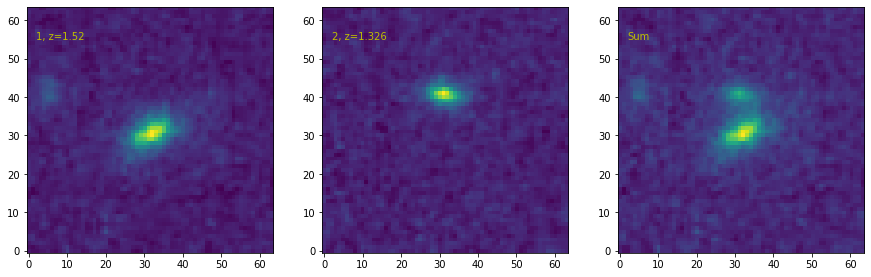

In [156]:
he, he2= galblend(gals=2,lim_hmag=24.5)


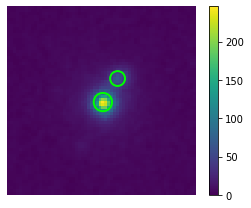

In [222]:
image, he2= galblend(gals=3,lim_hmag=24.5,plot_it=False)
back =np.mean(he2)
blobs_log = blob_log(image-back, min_sigma=0.1, max_sigma=5, num_sigma=20, threshold=back/2, overlap=0.95, log_scale=True, exclude_border=False)
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2) # Compute radii in the 3rd column.
blobs_list = [blobs_log]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

c = ax.imshow(image,origin='lower')
plt.colorbar(c)
for blob in blobs_log:
    y, x, r = blob
    if ((r>1)&(10<x<50)&(10<y<50)):
        c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
        ax.add_patch(c)
        ax.set_axis_off()
        

plt.tight_layout()


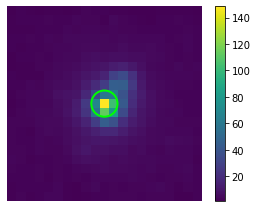

In [223]:
he3 = go_lowres(he2)

back =np.mean(he3)
blobs_log = blob_log(he3-back, min_sigma=1, max_sigma=10, num_sigma=20, threshold=back/2, overlap=0.9, log_scale=True, exclude_border=False)
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2) # Compute radii in the 3rd column.
blobs_list = [blobs_log]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

c = ax.imshow(he3,origin='lower')
plt.colorbar(c)
for blob in blobs_log:
    y, x, r = blob
    if ((r>0.2)&(3<x<18)&(3<y<18)):
        c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
        ax.add_patch(c)
        ax.set_axis_off()
        

plt.tight_layout()